# Import libs

In [15]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Read data

In [16]:
change_df = pd.read_csv('../../datasets/group_people.csv')
bots_df = pd.read_csv('../../datasets/bots.csv')
users_df = pd.read_csv('../../datasets/users.csv')
data = pd.concat([bots_df, users_df, change_df])


source_features = ['has_photo','has_mobile','is_friend','can_post','can_see_all_posts',
            'can_see_audio','can_write_private_message','can_send_friend_request',
            'can_be_invited_group','followers_count','blacklisted','blacklisted_by_me',
            'is_favorite','is_hidden_from_feed','common_count','university','faculty',
            'graduation','relation','verified','deactivated','friend_status','can_access_closed',
            'is_closed', 'city_id','country_id','last_seen_platform','last_seen_time',
            'interests_bool', 'books_bool', 'tv_bool', 'quotes_bool', 'about_bool',
            'games_bool', 'movies_bool', 'activities_bool', 'music_bool', 'mobile_phone_bool',
            'home_phone_bool', 'site_bool', 'status_bool', 'university_bool',
            'university_name_bool', 'faculty_bool', 'faculty_name_bool', 'graduation_bool',
            'home_town_bool', 'relation_bool', 'personal_bool', 'universities_bool',
            'schools_bool', 'occupation_bool', 'education_form_bool', 'education_status_bool',
            'relation_partner_bool', 'skype_bool', 'twitter_bool', 'livejournal_bool',
            'instagram_bool', 'facebook_bool', 'facebook_name_bool', 'relatives_in_friends_bool',
            'change_nickname_bool', 'partner_in_friends_bool', 'partner_in_friends_bool',
            'posts_count', 'users_subscriptions_count', 'groups_subscriptions_count',
            'albums_count', 'audios_count', 'gifts_count', 'pages_count', 'photos_count',
            'subscriptions_count', 'videos_count', 'video_playlists_count', 'subscriptions_followers_coef',
            'subscriptions_followers_coef_norm', 'friends_count']

# Feature selection

In [28]:
X = data[source_features]
y = data['bots']

# Создаем модель линейной регрессии
X.fillna(0, inplace=True)
model = LinearRegression()

# Выполняем RFE с использованием модели линейной регрессии
selected_features_list = []
features_numbers = list(range(10, 50, 5))
for i in features_numbers:
    rfe = RFE(model, n_features_to_select=i)
    fit = rfe.fit(X, y)

    # Добавляем результаты отбора признаков
    selected_features_list.append(list(np.compress(fit.support_, source_features)))

/var/folders/c9/vpcgc01n1lg_15lv6_k3t_r00000gn/T/ipykernel_71564/1245993805.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


# Class for collecting results

In [29]:
class Result:
    def __init__(self, selected_features, accuracy, precision, recall, auc, f1, fpr, tpr, roc_auc):
        self.selected_features = selected_features
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        self.auc = auc
        self.f1 = f1
        self.fpr = fpr
        self.tpr = tpr
        self.roc_auc = roc_auc
    
    @property
    def metrics_sum(self):
        return self.accuracy + self.precision + self.recall + self.auc + self.f1

# F1 score function

In [30]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))


# Train model

In [31]:
# Выбираем нужные признаки и целевую переменную
results = []
for selected_features in selected_features_list:
    # Разделяем данные на обучающую и тестовую выборки
    train_data, test_data, train_labels, test_labels = train_test_split(data[selected_features], data['bots'], test_size=0.2)
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    # Создаем модель нейронной сети
    model = tf.keras.Sequential([
        # Добавляем сверточный слой с 32 фильтрами, размером ядра 3х3 и активацией ReLU
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(train_data.shape[1], 1)),
        # Добавляем слой регуляризации для уменьшения переобучения
        MaxPooling1D(pool_size=2),
        # Добавляем слой регуляризации
        Dropout(0.25),
        # Преобразуем карты признаков в одномерный вектор
        Flatten(),
        # Добавляем полносвязный слой с 128 нейронами и активацией ReLU
        Dense(128, activation='relu'),
        # Добавляем еще один слой регуляризации
        Dropout(0.5),
        # Добавляем выходной слой с функцией активации sigmoid для бинарной классификации
        Dense(1, activation='sigmoid'),
    ])

    # Компилируем модель
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC', f1])

    # Обучаем модель
    history = model.fit(train_data, train_labels, epochs=9, batch_size=128, validation_data=(test_data, test_labels))

    # Оцениваем точность модели
    test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(test_data, test_labels)

    
    # Roc кривая
    y_score = model.predict(test_data)
    y_true = test_labels

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    
    # Создаем модель result
    result = Result(selected_features, test_accuracy, test_precision, test_recall, test_auc, test_f1, fpr, tpr, roc_auc)
    results.append(result)

Epoch 1/9
55/55 [==============================] - 5s 64ms/step - loss: 0.5547 - accuracy: 0.6936 - precision: 0.2289 - recall: 0.0498 - auc: 0.6701 - f1: 0.0379 - val_loss: 0.4576 - val_accuracy: 0.7325 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6566 - val_f1: 0.0000e+00
Epoch 2/9
55/55 [==============================] - 1s 22ms/step - loss: 0.4505 - accuracy: 0.7263 - precision: 0.5024 - recall: 0.1613 - auc: 0.7876 - f1: 0.2385 - val_loss: 0.4313 - val_accuracy: 0.7342 - val_precision: 0.8000 - val_recall: 0.0086 - val_auc: 0.9221 - val_f1: 0.0159
Epoch 3/9
55/55 [==============================] - 1s 19ms/step - loss: 0.4350 - accuracy: 0.7379 - precision: 0.5398 - recall: 0.2981 - auc: 0.8064 - f1: 0.3786 - val_loss: 0.4256 - val_accuracy: 0.7641 - val_precision: 0.5400 - val_recall: 0.7961 - val_auc: 0.9231 - val_f1: 0.6426
Epoch 4/9
55/55 [==============================] - 1s 19ms/step - loss: 0.4288 - accuracy: 0.7665 - precision: 0.6336 - recall: 0.3515 -

55/55 [==============================] - 0s 3ms/step
Epoch 1/9
55/55 [==============================] - 7s 100ms/step - loss: 0.4507 - accuracy: 0.7951 - precision: 0.7332 - recall: 0.3994 - auc: 0.8088 - f1: 0.4983 - val_loss: 0.3311 - val_accuracy: 0.8410 - val_precision: 0.7729 - val_recall: 0.5671 - val_auc: 0.9063 - val_f1: 0.6558
Epoch 2/9
55/55 [==============================] - 1s 25ms/step - loss: 0.3410 - accuracy: 0.8452 - precision: 0.7897 - recall: 0.5949 - auc: 0.9001 - f1: 0.6761 - val_loss: 0.3036 - val_accuracy: 0.8657 - val_precision: 0.8081 - val_recall: 0.6472 - val_auc: 0.9160 - val_f1: 0.7212
Epoch 3/9
55/55 [==============================] - 1s 22ms/step - loss: 0.3222 - accuracy: 0.8544 - precision: 0.7928 - recall: 0.6362 - auc: 0.9095 - f1: 0.7023 - val_loss: 0.3002 - val_accuracy: 0.8542 - val_precision: 0.8824 - val_recall: 0.5195 - val_auc: 0.9196 - val_f1: 0.6557
Epoch 4/9
55/55 [==============================] - 1s 21ms/step - loss: 0.3106 - accuracy: 0.8

55/55 [==============================] - 0s 3ms/step
Epoch 1/9
55/55 [==============================] - 7s 105ms/step - loss: 0.4595 - accuracy: 0.7951 - precision: 0.7559 - recall: 0.3838 - auc: 0.7950 - f1: 0.4846 - val_loss: 0.3216 - val_accuracy: 0.8680 - val_precision: 0.8466 - val_recall: 0.5928 - val_auc: 0.9000 - val_f1: 0.6963
Epoch 2/9
55/55 [==============================] - 1s 27ms/step - loss: 0.3391 - accuracy: 0.8481 - precision: 0.8103 - recall: 0.5892 - auc: 0.8975 - f1: 0.6780 - val_loss: 0.2819 - val_accuracy: 0.8754 - val_precision: 0.8159 - val_recall: 0.6644 - val_auc: 0.9250 - val_f1: 0.7297
Epoch 3/9
55/55 [==============================] - 1s 22ms/step - loss: 0.3102 - accuracy: 0.8640 - precision: 0.8195 - recall: 0.6525 - auc: 0.9160 - f1: 0.7230 - val_loss: 0.2753 - val_accuracy: 0.8806 - val_precision: 0.7965 - val_recall: 0.7181 - val_auc: 0.9285 - val_f1: 0.7529
Epoch 4/9
55/55 [==============================] - 1s 23ms/step - loss: 0.2959 - accuracy: 0.8

# Plot graphs of metrics

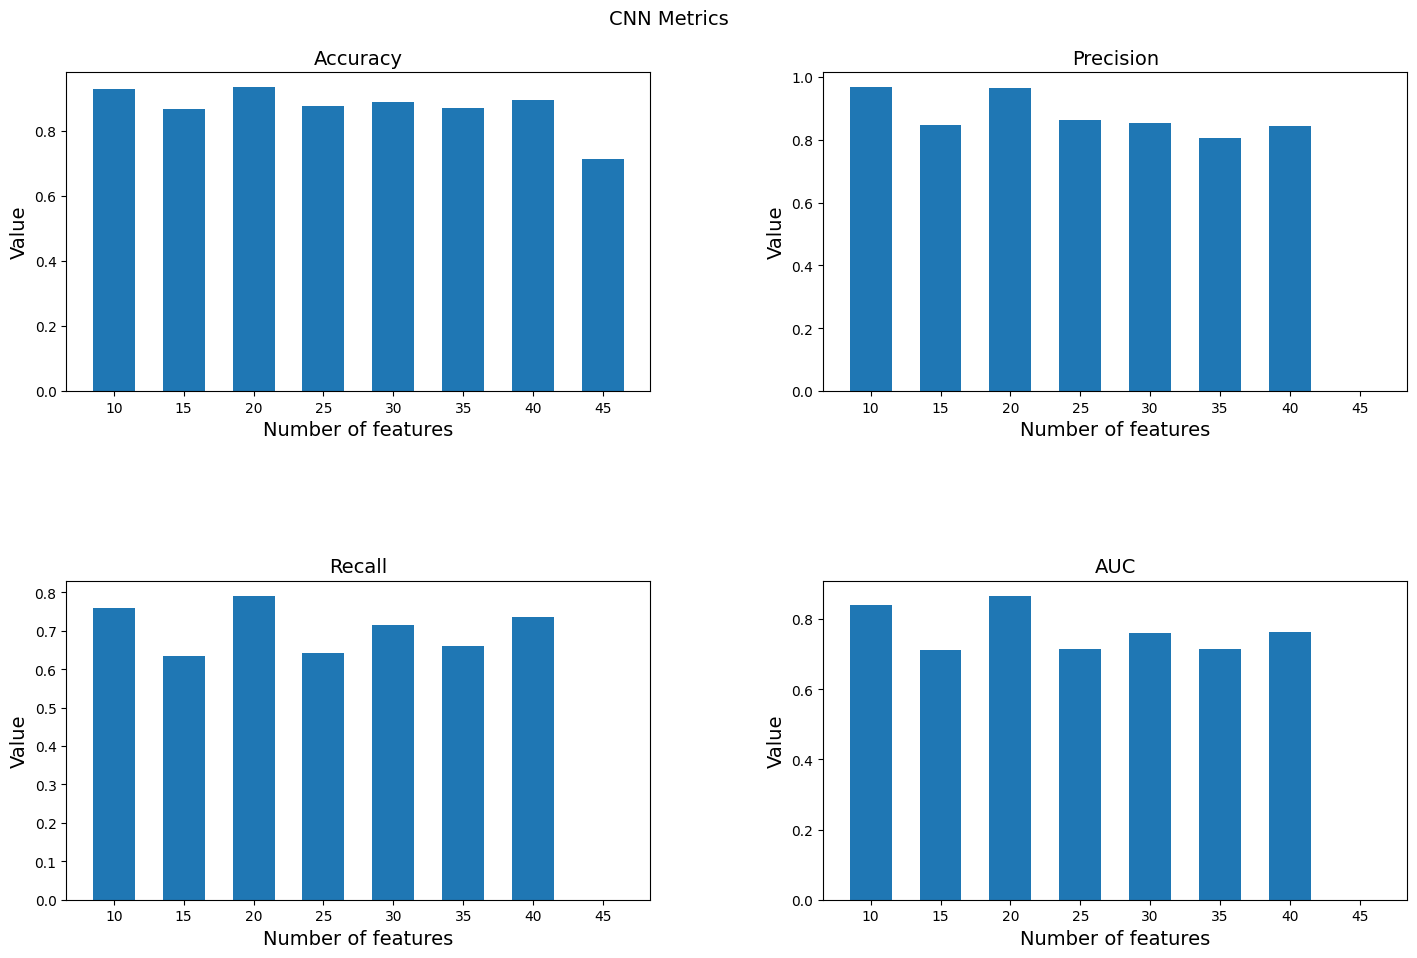

In [32]:
# Строим график столбцов
accuracy_values = [result.accuracy for result in results]
precision_values = [result.precision for result in results]
recall_values = [result.recall for result in results]
auc_values = [result.auc for result in results]
f1_values = [result.f1 for result in results]

# Добавляем заголовок и подписи осей
fig, axs = plt.subplots(2, 2)

# Первый график
axs[0, 0].bar(features_numbers, accuracy_values, width=3)
axs[0, 0].set_title('Accuracy', fontsize=14)
axs[0, 0].set_xlabel('Number of features', fontsize=14)
axs[0, 0].set_ylabel('Value', fontsize=14)

# Второй график
axs[0, 1].bar(features_numbers, precision_values, width=3)
axs[0, 1].set_title('Precision', fontsize=14)
axs[0, 1].set_xlabel('Number of features', fontsize=14)
axs[0, 1].set_ylabel('Value', fontsize=14)

# Третий график
axs[1, 0].bar(features_numbers, recall_values, width=3)
axs[1, 0].set_title('Recall', fontsize=14)
axs[1, 0].set_xlabel('Number of features', fontsize=14)
axs[1, 0].set_ylabel('Value', fontsize=14)

# Четвертый график
axs[1, 1].bar(features_numbers, f1_values, width=3)
axs[1, 1].set_title('AUC', fontsize=14)
axs[1, 1].set_xlabel('Number of features', fontsize=14)
axs[1, 1].set_ylabel('Value', fontsize=14)

# Настраиваем расположение графиков и добавляем общий заголовок
fig.tight_layout()
fig.suptitle('CNN Metrics', fontsize=14)

# Сохраняем график
fig.set_size_inches(15.5, 10.5, forward=True)
fig.savefig('Metrics.png', dpi=300)
plt.show()

# Plot ROC curves

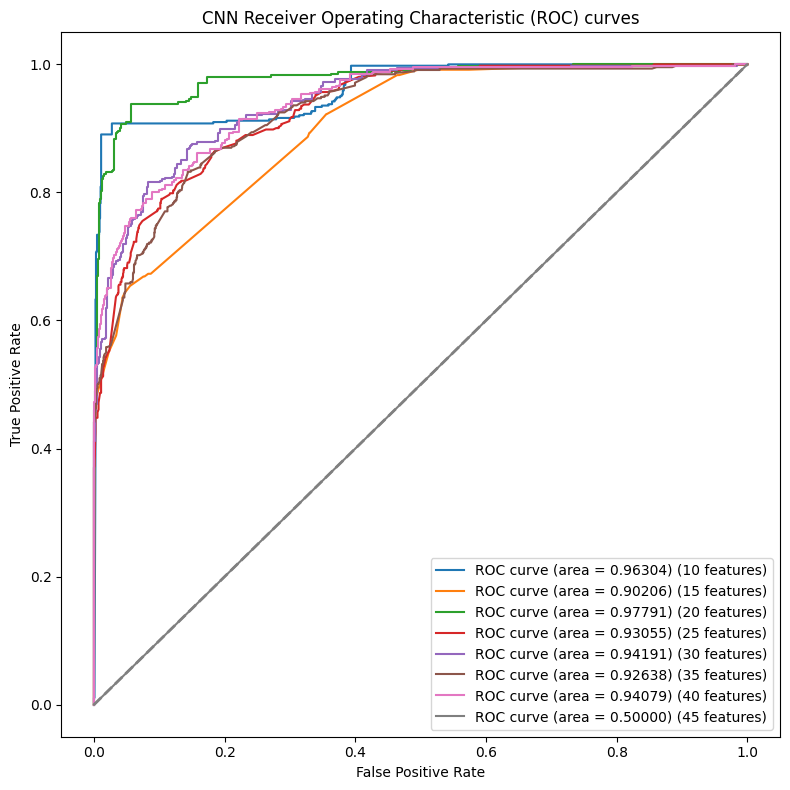

In [33]:
fig = plt.figure(figsize=(8, 8))

# Строим ROC кривые
for i in range(len(results)):
    plt.plot(
        results[i].fpr,
        results[i].tpr,
        label=f'ROC curve (area = %0.5f) ({len(results[i].selected_features)} features)'% results[i].roc_auc
    )

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (ROC) curves')
plt.legend(loc="lower right")

# Сохраняем график
fig.tight_layout()
plt.savefig('ROC-curves.png', dpi=300)
plt.show()